In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from stargazer.stargazer import Stargazer
import glob

sns.set_context("paper", font_scale=1.6)
sns.set_style(
    "ticks",
    {
        "axes.grid": True,
        "grid.color": "0.95",
        "grid.linestyle": "-",
        "axes.facecolor": "white",
        "figure.facecolor": "#FAFAFA",
    },
)

# Import Return Data

In [2]:
%%time
data_files = glob.glob("../data/returns/ticker_returns/*.feather")[:200]
cols_keep = ['date', 'datetime', 'ticker', 'log_price', 'return', 'return_p2']

ticker_dfs = []
for ticker_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    ticker_dfs.append(ticker_df[cols_keep].set_index(['ticker', 'datetime']))

data_returns_df = pd.concat(ticker_dfs).sort_index()


CPU times: user 24.3 s, sys: 34 s, total: 58.3 s
Wall time: 43.6 s


# Import BM Data

In [3]:
%%time
data_bm_df = pd.read_csv('../data/wrds/book_to_market.csv')

# Get book-to-market ratios
data_bm_df['BM'] = (data_bm_df['bkvlps'] * data_bm_df['csho']) / data_bm_df['mkvalt']
data_bm_df['year'] = pd.to_datetime(data_bm_df['datadate'].astype(str)).dt.year
data_bm_df['ticker'] = data_bm_df['tic']

# Trim by BM
upper_bd = data_bm_df['BM'].quantile(0.99)
lower_bd = data_bm_df['BM'].quantile(0.01)
data_bm_df = data_bm_df.query('BM < @upper_bd & BM > @lower_bd')

data_bm_df.head()

CPU times: user 78.1 ms, sys: 15.6 ms, total: 93.8 ms
Wall time: 181 ms


,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,...,bkvlps,csho,exchg,cik,costat,fic,mkvalt,BM,year,ticker
4,1045,20141231,2014.0,INDL,C,D,STD,AAL,02376R102,AMERICAN AIRLINES GROUP INC,...,2.8976,697.475,14,6201,A,USA,37405.5843,0.054029,2014,AAL
5,1045,20151231,2015.0,INDL,C,D,STD,AAL,02376R102,AMERICAN AIRLINES GROUP INC,...,9.0215,624.622,14,6201,A,USA,26452.7417,0.213022,2015,AAL
6,1045,20161231,2016.0,INDL,C,D,STD,AAL,02376R102,AMERICAN AIRLINES GROUP INC,...,7.4612,507.294,14,6201,A,USA,23685.5569,0.159803,2016,AAL
7,1045,20171231,2017.0,INDL,C,D,STD,AAL,02376R102,AMERICAN AIRLINES GROUP INC,...,8.2564,475.508,14,6201,A,USA,24740.6812,0.158685,2017,AAL
8,1045,20181231,2018.0,INDL,C,D,STD,AAL,02376R102,AMERICAN AIRLINES GROUP INC,...,-0.3669,460.611,14,6201,A,USA,14790.2192,-0.011426,2018,AAL


# Import Beta Data

In [4]:
%%time
data_capm_df = pd.read_csv('../data/wrds/capm_betas.csv')

# Clean up cols
data_capm_df['ticker'] = data_capm_df['TICKER']
data_capm_df['date'] = pd.to_datetime(data_capm_df['DATE'].astype(str)).dt.date

data_capm_df.head()

CPU times: user 531 ms, sys: 125 ms, total: 656 ms
Wall time: 658 ms


,PERMNO,DATE,n,RET,b_mkt,alpha,ivol,tvol,R2,exret,TICKER,ticker,date
0,10104,20190321,252,2.6596%,0.9124,0.0004,1.0550%,1.4202%,44.8149%,1.6215%,ORCL,ORCL,2019-03-21
1,10104,20190731,252,-2.0699%,0.9389,0.0005,0.9472%,1.3368%,49.7909%,-1.0733%,ORCL,ORCL,2019-07-31
2,10104,20190430,252,0.4539%,0.8950,0.0004,1.0461%,1.3590%,40.7496%,0.4787%,ORCL,ORCL,2019-04-30
3,10104,20190516,252,0.1466%,0.8890,0.0004,1.0446%,1.3658%,41.4983%,-0.6692%,ORCL,ORCL,2019-05-16
4,10104,20190411,252,-0.3335%,0.8920,0.0004,1.0503%,1.3655%,40.8462%,-0.3441%,ORCL,ORCL,2019-04-11


In [5]:
%%time
data_ff_df = pd.read_csv('../data/wrds/ff_betas.csv')

# Clean up cols
data_ff_df['ticker'] = data_ff_df['TICKER']
data_ff_df['date'] = pd.to_datetime(data_ff_df['DATE'].astype(str)).dt.date

data_ff_df.head()

CPU times: user 4.8 s, sys: 1.02 s, total: 5.81 s
Wall time: 5.81 s


,PERMNO,DATE,n,RET,alpha,b_mkt,b_smb,b_hml,ivol,tvol,R2,exret,TICKER,ticker,date
0,10104,20100930,252,-1.1760%,0.0003,1.2053,-0.1430,-0.7747,1.1117%,1.5856%,50.8410%,-0.6639%,ORCL,ORCL,2010-09-30
1,10104,20100527,252,3.0603%,-0.0000,1.2647,-0.0577,-0.7989,1.0240%,1.5128%,54.1763%,0.0239%,ORCL,ORCL,2010-05-27
2,10104,20120821,252,-0.9051%,-0.0002,1.2643,-0.1112,-0.6460,1.2734%,1.9753%,58.4382%,-0.2398%,ORCL,ORCL,2012-08-21
3,10104,20120224,252,1.5272%,-0.0010,1.2967,0.0372,-0.8066,1.2564%,2.2570%,69.0114%,0.8310%,ORCL,ORCL,2012-02-24
4,10104,20130424,252,0.1540%,-0.0002,1.2057,-0.0016,-0.1539,1.0632%,1.4567%,46.7332%,0.2801%,ORCL,ORCL,2013-04-24


# Spot Volatility

In [24]:
def get_spotvol_before_after(
    ticker_returns_df, ticker, event_time, time_gap, time_width, diag=False
):

    event_idx = np.searchsorted(ticker_returns_df["datetime"], event_time)
    ticker_returns_df.iloc[range(event_idx - time_gap, event_idx + time_gap + 1), :]

    before_ticker_returns_df = ticker_returns_df.iloc[
        range(event_idx - time_gap - time_width + 1, event_idx - time_gap + 1)
    ]
    after_ticker_returns_df = ticker_returns_df.iloc[
        range(event_idx + time_gap, event_idx + time_gap + time_width)
    ]

    if diag:
        display(before_ticker_returns_df)
        display(after_ticker_returns_df)

    # Convert RV to daily
    rv_adjust_factor = 78 / time_width

    # Compute spot vol
    spot_vol_before = np.sum(before_ticker_returns_df["return_p2"]) * rv_adjust_factor
    spot_vol_after =np.sum(after_ticker_returns_df["return_p2"]) * rv_adjust_factor
    
    return [ticker, event_time, spot_vol_before, spot_vol_after]

In [7]:
# Params
tickers = list(set(data_returns_df.index.get_level_values(0)))

In [9]:
fed_minutes_datetimes = pd.read_csv('../data/keys/fed_minutes.txt', header = None, sep = '\n')
fed_minutes_datetimes.columns = ['datetime_unfmt']
fed_minutes_datetimes['datetime'] = pd.to_datetime(fed_minutes_datetimes['datetime_unfmt'].map(str))

data_datetime_index = data_returns_df.loc[('A'),:].index
date_min, date_max = data_datetime_index.min(), data_datetime_index.max()
fed_minutes_datetimes = fed_minutes_datetimes.loc[ 
    (fed_minutes_datetimes['datetime'] < date_max) &  (fed_minutes_datetimes['datetime'] > date_min)
    ,:]
fed_minutes_datetimes = fed_minutes_datetimes.sort_values(by = 'datetime')

display(fed_minutes_datetimes.head())
display(fed_minutes_datetimes.tail())

,datetime_unfmt,datetime
47,"Jan 08, 2014 14:00",2014-01-08 14:00:00
46,"Feb 19, 2014 14:00",2014-02-19 14:00:00
45,"Apr 09, 2014 13:00",2014-04-09 13:00:00
44,"May 21, 2014 13:00",2014-05-21 13:00:00
43,"Jul 09, 2014 13:00",2014-07-09 13:00:00


,datetime_unfmt,datetime
4,"May 22, 2019 13:00",2019-05-22 13:00:00
3,"Jul 10, 2019 13:00",2019-07-10 13:00:00
2,"Aug 21, 2019 13:00",2019-08-21 13:00:00
1,"Oct 09, 2019 13:00",2019-10-09 13:00:00
0,"Nov 20, 2019 14:00",2019-11-20 14:00:00


In [46]:
# More params
time_gap = 6
time_width = 6

results = []

def temp_f(ticker):
    
    temp_results = []
    ticker_returns_df = data_returns_df.loc[(ticker),:].reset_index()
    
    for event_time in (fed_minutes_datetimes['datetime'].values):
        
        temp_results.append(get_spotvol_before_after(ticker_returns_df, ticker, event_time, time_gap, time_width))
    
    return temp_results

with Pool(8) as p:

    for result in tqdm(p.imap_unordered(temp_f, tickers), total = len(tickers)):
        
        results = results + result

In [49]:
results_df = pd.DataFrame(results, columns = ['ticker', 'event_time', 'spotvol_before', 'spotvol_after'])
results_df

,ticker,event_time,spotvol_before,spotvol_after
0,ARE,2014-01-08 14:00:00,0.000032,0.000080
1,ARE,2014-02-19 14:00:00,0.000139,0.000028
2,ARE,2014-04-09 13:00:00,0.000026,0.000031
3,ARE,2014-05-21 13:00:00,0.000024,0.000015
4,ARE,2014-07-09 13:00:00,0.000029,0.000009
...,...,...,...,...
9595,ATVI,2019-05-22 13:00:00,0.000323,0.001094
9596,ATVI,2019-07-10 13:00:00,0.000323,0.001094
9597,ATVI,2019-08-21 13:00:00,0.000182,0.000071
9598,ATVI,2019-10-09 13:00:00,0.000090,0.000150


,ticker,event_time,spotvol_before,spotvol_after,datetime,date,spotvol_diff,PERMNO,DATE,n,RET,alpha,b_mkt,b_smb,b_hml,ivol,tvol,R2,exret,TICKER
0,ARE,2014-01-08 14:00:00,0.000032,0.000080,2014-01-08 14:00:00,2014-01-08,0.907297,84767,20140108,252,-0.2176%,-0.0013,0.9417,-0.0199,-0.3600,0.9380%,1.1389%,32.1626%,-0.2950%,ARE
1,ARE,2014-02-19 14:00:00,0.000139,0.000028,2014-02-19 14:00:00,2014-02-19,-1.616621,84767,20140219,252,0.0689%,-0.0006,0.8270,0.0392,-0.3034,0.9785%,1.1625%,29.1454%,0.5666%,ARE
2,ARE,2014-04-09 13:00:00,0.000026,0.000031,2014-04-09 13:00:00,2014-04-09,0.164263,84767,20140409,252,-0.2602%,-0.0003,0.7659,-0.0177,-0.2256,1.0321%,1.1846%,24.0882%,-1.4194%,ARE
3,ARE,2014-05-21 13:00:00,0.000024,0.000015,2014-05-21 13:00:00,2014-05-21,-0.494849,84767,20140521,252,-0.2528%,-0.0003,0.7362,-0.0840,-0.2636,1.0290%,1.1670%,22.2593%,-0.8498%,ARE
4,ARE,2014-07-09 13:00:00,0.000029,0.000009,2014-07-09 13:00:00,2014-07-09,-1.165567,84767,20140709,252,-0.0645%,0.0002,0.5644,-0.0602,-0.2256,0.9175%,0.9990%,15.6392%,-0.3770%,ARE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9615,ATVI,2019-05-22 13:00:00,0.000323,0.001094,2019-05-22 13:00:00,2019-05-22,1.218670,79678,20190522,252,-1.2428%,-0.0028,0.9306,0.0744,-1.1946,2.2339%,2.6580%,29.3704%,-1.5756%,ATVI
9616,ATVI,2019-07-10 13:00:00,0.000323,0.001094,2019-07-10 13:00:00,2019-07-10,1.218670,79678,20190710,252,1.0136%,-0.0027,0.9332,0.1493,-1.0994,2.2796%,2.6892%,28.1431%,0.2222%,ATVI
9617,ATVI,2019-08-21 13:00:00,0.000182,0.000071,2019-08-21 13:00:00,2019-08-21,-0.946778,79678,20190821,252,0.4918%,-0.0020,1.0584,0.0996,-0.9613,2.3087%,2.7468%,29.3542%,-0.7159%,ATVI
9618,ATVI,2019-10-09 13:00:00,0.000090,0.000150,2019-10-09 13:00:00,2019-10-09,0.512930,79678,20191009,252,-1.2932%,-0.0018,1.0941,0.1012,-0.7664,2.3266%,2.7503%,28.4365%,-2.3549%,ATVI


In [71]:
results_df = pd.DataFrame(results, columns = ['ticker', 'event_time', 'spotvol_before', 'spotvol_after'])

# Add date
results_df['datetime'] = pd.to_datetime(results_df['event_time'])
results_df['date'] = results_df['datetime'].dt.date
results_df['year'] = results_df['datetime'].dt.year

# Get log diff in spot vol
results_df['spotvol_diff'] =  np.log(results_df['spotvol_after']) - np.log(results_df['spotvol_before'])

# Skip inf values
results_df = results_df.loc[~results_df['spotvol_diff'].replace([np.inf, -np.inf], np.nan).isna(), ]

# Merge with other data
results_df = results_df.merge(data_ff_df, on = ['date', 'ticker'])

# Fix dates
results_df['date'] = pd.to_datetime(results_df['date'])

results_df

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ticker,event_time,spotvol_before,spotvol_after,datetime,date,year,spotvol_diff,PERMNO,DATE,...,RET,alpha,b_mkt,b_smb,b_hml,ivol,tvol,R2,exret,TICKER
0,ARE,2014-01-08 14:00:00,0.000032,0.000080,2014-01-08 14:00:00,2014-01-08,2014,0.907297,84767,20140108,...,-0.2176%,-0.0013,0.9417,-0.0199,-0.3600,0.9380%,1.1389%,32.1626%,-0.2950%,ARE
1,ARE,2014-02-19 14:00:00,0.000139,0.000028,2014-02-19 14:00:00,2014-02-19,2014,-1.616621,84767,20140219,...,0.0689%,-0.0006,0.8270,0.0392,-0.3034,0.9785%,1.1625%,29.1454%,0.5666%,ARE
2,ARE,2014-04-09 13:00:00,0.000026,0.000031,2014-04-09 13:00:00,2014-04-09,2014,0.164263,84767,20140409,...,-0.2602%,-0.0003,0.7659,-0.0177,-0.2256,1.0321%,1.1846%,24.0882%,-1.4194%,ARE
3,ARE,2014-05-21 13:00:00,0.000024,0.000015,2014-05-21 13:00:00,2014-05-21,2014,-0.494849,84767,20140521,...,-0.2528%,-0.0003,0.7362,-0.0840,-0.2636,1.0290%,1.1670%,22.2593%,-0.8498%,ARE
4,ARE,2014-07-09 13:00:00,0.000029,0.000009,2014-07-09 13:00:00,2014-07-09,2014,-1.165567,84767,20140709,...,-0.0645%,0.0002,0.5644,-0.0602,-0.2256,0.9175%,0.9990%,15.6392%,-0.3770%,ARE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9614,ATVI,2019-05-22 13:00:00,0.000323,0.001094,2019-05-22 13:00:00,2019-05-22,2019,1.218670,79678,20190522,...,-1.2428%,-0.0028,0.9306,0.0744,-1.1946,2.2339%,2.6580%,29.3704%,-1.5756%,ATVI
9615,ATVI,2019-07-10 13:00:00,0.000323,0.001094,2019-07-10 13:00:00,2019-07-10,2019,1.218670,79678,20190710,...,1.0136%,-0.0027,0.9332,0.1493,-1.0994,2.2796%,2.6892%,28.1431%,0.2222%,ATVI
9616,ATVI,2019-08-21 13:00:00,0.000182,0.000071,2019-08-21 13:00:00,2019-08-21,2019,-0.946778,79678,20190821,...,0.4918%,-0.0020,1.0584,0.0996,-0.9613,2.3087%,2.7468%,29.3542%,-0.7159%,ATVI
9617,ATVI,2019-10-09 13:00:00,0.000090,0.000150,2019-10-09 13:00:00,2019-10-09,2019,0.512930,79678,20191009,...,-1.2932%,-0.0018,1.0941,0.1012,-0.7664,2.3266%,2.7503%,28.4365%,-2.3549%,ATVI


In [72]:
# smf.ols('spotvol_diff ~ BM ', results_df).fit().summary()

### FF Approach

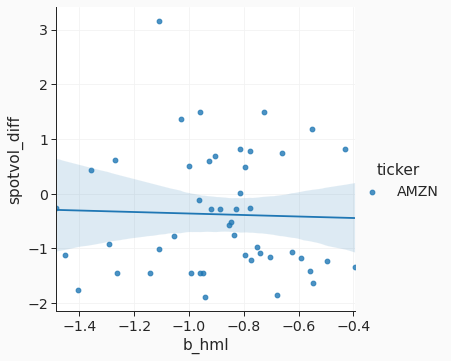

In [73]:
sns.lmplot(x = 'b_hml', y = 'spotvol_diff', hue = 'ticker', data = results_df.query('ticker == "AMZN"'))

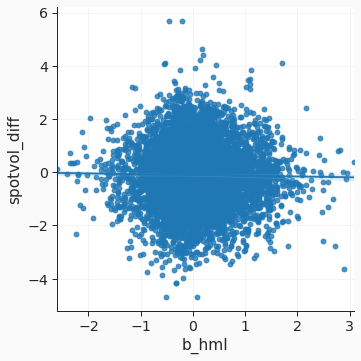

In [74]:
sns.lmplot(x = 'b_hml', y = 'spotvol_diff', data = results_df.loc[results_df['date'] < "2019-01-01", :])

In [86]:
smf.ols('spotvol_diff ~ np.square(b_hml) ', results_df.query('year < 2020')).fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           spotvol_diff   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.714
Date:                Sat, 07 Nov 2020   Prob (F-statistic):            0.00549
Time:                        14:50:08   Log-Likelihood:                -15008.
No. Observations:                9619   AIC:                         3.002e+04
Df Residuals:                    9617   BIC:                         3.003e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0367      0.013     -2.759      0.006      -0.063      -0.011
np.square(b_hml)    -0.0458      0.016     -2.777      0.005      -0.078      -0.013
==============================================================================
Omnibus:                       44.242   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.809
Skew:                           0.006   Prob(JB):                     3.79e-14
Kurtosis:                       3.393   Cond. No.                         1.76
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [98]:
results_df.head()

,ticker,event_time,spotvol_before,spotvol_after,datetime,date,year,spotvol_diff,PERMNO,DATE,...,alpha,b_mkt,b_smb,b_hml,ivol,tvol,R2,exret,TICKER,b_hml_lag
9139,A,2014-01-08 14:00:00,0.000094,0.000073,2014-01-08 14:00:00,2014-01-08,2014,-0.251770,87432,20140108,...,0.0001,1.1000,0.3739,-0.0072,1.1051%,1.3823%,36.0859%,1.5751%,A,NaN
9140,A,2014-02-19 14:00:00,0.000066,0.000026,2014-02-19 14:00:00,2014-02-19,2014,-0.951589,87432,20140219,...,0.0001,1.0674,0.3381,-0.0917,1.2092%,1.4862%,33.7991%,2.2986%,A,-0.0072
9141,A,2014-04-09 13:00:00,0.000015,0.000075,2014-04-09 13:00:00,2014-04-09,2014,1.597881,87432,20140409,...,0.0002,1.1072,0.2209,-0.1258,1.2042%,1.4939%,35.0241%,0.3877%,A,-0.0917
9142,A,2014-05-21 13:00:00,0.000048,0.000022,2014-05-21 13:00:00,2014-05-21,2014,-0.792707,87432,20140521,...,0.0001,1.0964,0.2075,-0.1715,1.1417%,1.4343%,36.6368%,0.4353%,A,-0.1258
9143,A,2014-07-09 13:00:00,0.000033,0.000029,2014-07-09 13:00:00,2014-07-09,2014,-0.130256,87432,20140709,...,0.0002,1.0659,0.2105,-0.1612,1.1344%,1.3836%,32.7785%,-0.8708%,A,-0.1715


<AxesSubplot:xlabel='b_hml', ylabel='spotvol_diff'>

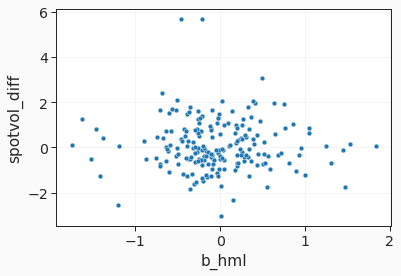

In [106]:
sns.scatterplot(x = 'b_hml', y = 'spotvol_diff', data = results_df.query('event_time == "2014-02-19 14:00:00"'))

In [91]:
results_df = results_df.sort_values(by = ['ticker', 'datetime'])
results_df['b_hml_lag'] = results_df.groupby('ticker')['b_hml'].shift(1)

In [107]:
smf.ols('spotvol_diff ~ b_hml + np.power(b_hml, 2) ', results_df.query('year < 2020')).fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           spotvol_diff   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.765
Date:                Sat, 07 Nov 2020   Prob (F-statistic):            0.00854
Time:                        14:54:47   Log-Likelihood:                -15007.
No. Observations:                9619   AIC:                         3.002e+04
Df Residuals:                    9616   BIC:                         3.004e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0380      0.013     -2.853      0.004      -0.064      -0.012
b_hml                 -0.0261      0.020     -1.310      0.190      -0.065       0.013
np.power(b_hml, 2)    -0.0395      0.017     -2.308      0.021      -0.073      -0.006
==============================================================================
Omnibus:                       44.789   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.726
Skew:                           0.005   Prob(JB):                     2.39e-14
Kurtosis:                       3.395   Cond. No.                         2.09
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""